# NBA Player Performance Predictor #

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("PlayerStatistics.csv")

In [3]:
data.head()

,firstName,gameDate,playerteamName,opponentteamName,win,home,MP,PTS,AST,BLK,...,FG,FG%,3PA,3PM,3P%,FTA,FTM,FT%,TRB,TOV
0,Alex Sarr,2025-04-13,Wizards,Heat,1,0,15.32,10,4,0,...,3,0.500,2,1,0.5,4,3,0.75,8,0
1,Bol Bol,2025-03-26,Suns,Celtics,0,1,6.26,8,0,1,...,3,1.000,2,2,1.0,0,0,0.00,1,0
2,Bol Bol,2025-03-17,Suns,Raptors,1,1,5.32,4,1,0,...,2,1.000,0,0,0.0,0,0,0.00,1,0
3,Malik Monk,2025-03-14,Kings,Suns,0,0,42.02,18,5,0,...,8,0.444,8,0,0.0,2,2,1.00,8,4
4,Bol Bol,2025-03-14,Suns,Kings,1,1,0.43,0,0,0,...,0,0.000,0,0,0.0,0,0,0.00,1,0


In [4]:
# Clean Name Version

In [5]:
from unidecode import unidecode

In [6]:
data['name'] = data['firstName'].str.lower().apply(unidecode)

In [8]:
player_name = input("Enter NBA player name: ")
opponent_input = input("Enter Opp Team Name: ")

Enter NBA player name:  Nikola Jokic
Enter Opp Team Name:  Celtics


In [9]:
player = unidecode(player_name.lower())

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
le = LabelEncoder()
data['opponent'] = le.fit_transform(data['opponentteamName'])

# Compute Rolling Averages

In [12]:
stats = ['MP','FGA','FG%','3PA','3P%','FTA','FT%','AST','TRB','TOV','PTS']
for stat in stats:
    data[f'new {stat}'] = data.groupby('name')[stat].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

In [13]:
player_data = data[data['name'] == player]

In [14]:
player_data.head()

,firstName,gameDate,playerteamName,opponentteamName,win,home,MP,PTS,AST,BLK,...,new FGA,new FG%,new 3PA,new 3P%,new FTA,new FT%,new AST,new TRB,new TOV,new PTS
18,Nikola Jokic,2025-04-13,Nuggets,Rockets,1,0,30.46,18,7,1,...,10.000000,0.700000,5.000000,0.600000,2.000000,0.500000,7.000000,7.000000,1.000000,18.000000
443,Nikola Jokic,2025-04-11,Nuggets,Grizzlies,1,1,40.55,26,13,0,...,14.500000,0.639500,3.500000,0.550000,4.500000,0.464500,10.000000,11.500000,3.000000,22.000000
804,Nikola Jokic,2025-04-09,Nuggets,Kings,1,0,37.42,20,11,0,...,13.666667,0.565333,2.666667,0.366667,6.333333,0.643000,10.333333,11.666667,2.333333,21.333333
1231,Nikola Jokic,2025-04-06,Nuggets,Pacers,0,1,39.00,41,13,1,...,21.333333,0.513667,4.666667,0.257667,6.666667,0.698667,12.333333,14.333333,3.333333,29.000000
1566,Nikola Jokic,2025-04-04,Nuggets,Warriors,0,0,37.12,33,9,0,...,20.666667,0.575667,6.333333,0.281333,5.333333,0.889000,11.000000,13.000000,3.666667,31.333333


In [15]:
new_data = [f'new {col}' for col in stats] + ['opponent']
X = data[new_data]
y = data[['PTS', 'AST', 'TRB']]

# Create train and test data

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 10, 20]
}

In [19]:
from sklearn.model_selection import GridSearchCV

# Use RandomForest Regression to compute future statistics

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
model = RandomForestRegressor()

In [22]:
search = GridSearchCV(estimator = model, param_grid = param_grid, cv=3)

In [23]:
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 150, 200]})

In [25]:
best_model = search.best_estimator_

In [26]:
y_pred = best_model.predict(X_test)

# Test room for error

In [27]:
from sklearn.metrics import mean_absolute_error, r2_score

In [28]:
mean_absolute_error(y_test, y_pred)

2.0205893216150628

In [29]:
r2_score(y_test, y_pred)

0.693930124631295

# Encode Opponent 

In [30]:
chosen_team = None
for team in data['opponentteamName']:
    if opponent_input == team:
        chosen_team = team

chosen_opponent = le.transform([chosen_team])[0]

In [31]:
last_game = player_data.tail(1)[new_data].copy()
last_game['opponent'] = chosen_opponent

# Final Prediction

In [32]:
prediction = best_model.predict(last_game)[0]
points = int(round(prediction[0]))
assists = int(round(prediction[1]))
rebounds = int(round(prediction[2]))

In [33]:
points

26

In [34]:
assists

9

In [35]:
rebounds

11

In [36]:
prediction

array([26.35835772,  9.38763968, 11.34527448])

# Visualization

In [41]:
import matplotlib.pyplot as plt

In [42]:
import seaborn as sns

# Actual vs Predicted

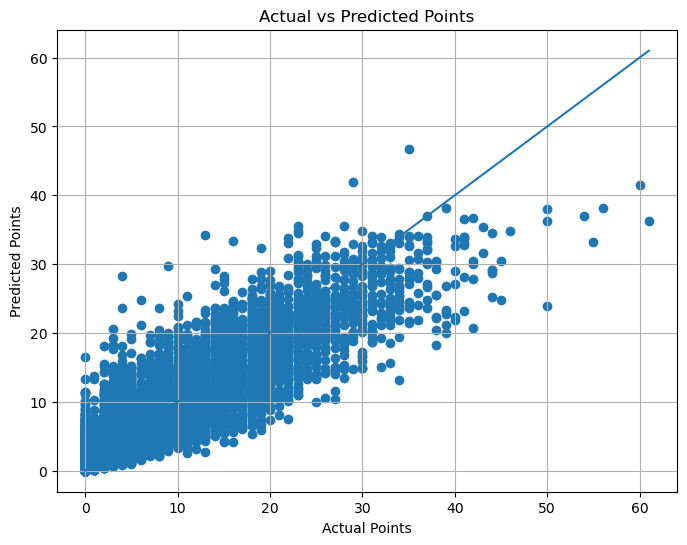

In [175]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test['PTS'].min(), y_test['PTS'].max()],
         [y_test['PTS'].min(), y_test['PTS'].max()])  # Reference line y=x

plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.grid(True)
plt.show()